In [1]:
import amici
import amici.plotting
import pesto

## AMICI model

{'ptr': <amici.amici.ExpData; proxy of <Swig Object of type 'std::unique_ptr< amici::ExpData >::pointer' at 0x122ed65a0> >, 'my': array([[ 1.05049371, -0.04077548],
       [ 0.81579596,  0.34565004],
       [ 1.07014655,  0.17475266],
       [ 0.66765117,  0.23241507],
       [ 0.57906533,  0.05980543],
       [ 0.65696485,  0.27146606],
       [ 0.65735443,  0.22704497],
       [ 0.76467159,  0.31613525],
       [ 0.67326   ,  0.15653353],
       [ 0.68266218,  0.26639863],
       [ 0.70913544,  0.47181205]]), 'sigmay': array([[0.1, 0.1],
       [0.1, 0.1],
       [0.1, 0.1],
       [0.1, 0.1],
       [0.1, 0.1],
       [0.1, 0.1],
       [0.1, 0.1],
       [0.1, 0.1],
       [0.1, 0.1],
       [0.1, 0.1],
       [0.1, 0.1]]), 'mz': None, 'sigmaz': None}


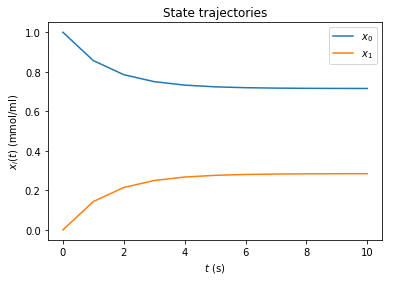

In [26]:
import libsbml
import importlib
import os
import sys
import numpy as np

# sbml file we want to import
sbml_file = 'example/model_conversion_reaction.xml'
# name of the model that will also be the name of the python module
model_name = 'model_conversion_reaction'
# directory to which the generated model code is written
model_output_dir = 'example/' + model_name

# import sbml model, complile and generate amici module
#sbml_importer = amici.SbmlImporter(sbml_file)
#sbml_importer.sbml2amici(model_name,
#                         model_output_dir,
#                         verbose=False)

# load amici module (the usual starting point later for the analysis)
sys.path.insert(0, os.path.abspath(model_output_dir))
model_module = importlib.import_module(model_name)
model = model_module.getModel()
model.requireSensitivitiesForAllParameters()
model.setTimepoints(amici.DoubleVector(np.linspace(0, 10, 11)))
model.setParameterScale(amici.AMICI_SCALING_LOG10)
model.setParameters(amici.DoubleVector([-0.3,-0.7]))
solver = model.getSolver()
solver.setSensitivityMethod(amici.AMICI_SENSI_FSA)
solver.setSensitivityOrder(amici.AMICI_SENSI_ORDER_FIRST)

# how to run amici now:
rdata = amici.runAmiciSimulation(model, solver, None)
amici.plotting.plotStateTrajectories(rdata)
edata = amici.ExpData(rdata['ptr'].get(), 0.1, 0.0)
print(amici.edataToNumPyArrays(edata))

## Optimization

In [ ]:
import os
import types
import importlib
import pesto
import pesto.optimize.optimizer
import pesto.optimize.optimize

def reload_package(package):
    assert(hasattr(package, "__package__"))
    fn = package.__file__
    fn_dir = os.path.dirname(fn) + os.sep
    module_visit = {fn}
    del fn

    def reload_recursive_ex(module):
        importlib.reload(module)

        for module_child in vars(module).values():
            if isinstance(module_child, types.ModuleType):
                fn_child = getattr(module_child, "__file__", None)
                if (fn_child is not None) and fn_child.startswith(fn_dir):
                    if fn_child not in module_visit:
                        print("reloading:", fn_child, "from", module)
                        module_visit.add(fn_child)
                        reload_recursive_ex(module_child)

    return reload_recursive_ex(package)

reload_package(pesto)

# create objective function from amici model
# pesto.AmiciObjective is derived from pesto.Objective, 
# the general pesto objective function class
objective = pesto.objective.AmiciObjective(model, solver, [edata], 1)

# create optimizer object which contains all information for doing the optimization
optimizer = pesto.optimize.optimizer.Optimizer(solver='scipy_BFGS')
#optimizer.solver = 'bfgs|meigo'
# if select meigo -> also set default values in solver_options
#optimizer.options = {'maxiter': 1000, 'disp': True} # = pesto.default_options_meigo()
#optimizer.startpoints = []
#optimizer.startpoint_method = 'lhs|uniform|something|function'
#optimizer.n_starts = 100

# see PestoOptions.m for more required options here
# returns OptimizationResult, see parameters.MS for what to return
# list of final optim results foreach multistart, times, hess, grad, 
# flags, meta information (which optimizer -> optimizer.get_repr())

# create problem object containing all information on the problem to be solved
problem = pesto.problem.Problem(objective, model)
problem.generate_starting_points(10)

# maybe lb, ub = inf
# other constraints: kwargs, class pesto.Constraints
# constraints on pams, states, esp. pesto.AmiciConstraints (e.g. pam1 + pam2<= const)
# if optimizer cannot handle -> error
# maybe also scaling / transformation of parameters encoded here

# do the optimization
result = pesto.optimize.optimize.optimize(problem, optimizer, result=None)
print(result)
# optimize is a function since it does not need an internal memory,
# just takes input and returns output in the form of a Result object
# 'result' parameter: e.g. some results from somewhere -> pick best start points

reloading: /Users/ffroehlich/Documents/GitHub/pyPESTO/pesto/objective.py from <module 'pesto' from '/Users/ffroehlich/Documents/GitHub/pyPESTO/pesto/__init__.py'>
reloading: /Users/ffroehlich/Documents/GitHub/pyPESTO/pesto/problem.py from <module 'pesto' from '/Users/ffroehlich/Documents/GitHub/pyPESTO/pesto/__init__.py'>
reloading: /Users/ffroehlich/Documents/GitHub/pyPESTO/pesto/result.py from <module 'pesto' from '/Users/ffroehlich/Documents/GitHub/pyPESTO/pesto/__init__.py'>
reloading: /Users/ffroehlich/Documents/GitHub/pyPESTO/pesto/version.py from <module 'pesto' from '/Users/ffroehlich/Documents/GitHub/pyPESTO/pesto/__init__.py'>
reloading: /Users/ffroehlich/Documents/GitHub/pyPESTO/pesto/optimize/__init__.py from <module 'pesto' from '/Users/ffroehlich/Documents/GitHub/pyPESTO/pesto/__init__.py'>
reloading: /Users/ffroehlich/Documents/GitHub/pyPESTO/pesto/optimize/optimizer.py from <module 'pesto.optimize' from '/Users/ffroehlich/Documents/GitHub/pyPESTO/pesto/optimize/__init__

/Users/ffroehlich/Documents/GitHub/pyPESTO/venv/lib/python3.6/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


/Users/ffroehlich/Documents/GitHub/pyPESTO/venv/lib/python3.6/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


/Users/ffroehlich/Documents/GitHub/pyPESTO/venv/lib/python3.6/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


/Users/ffroehlich/Documents/GitHub/pyPESTO/venv/lib/python3.6/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)
/Users/ffroehlich/Documents/GitHub/pyPESTO/venv/lib/python3.6/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)
/Users/ffroehlich/Documents/GitHub/pyPESTO/venv/lib/python3.6/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


/Users/ffroehlich/Documents/GitHub/pyPESTO/venv/lib/python3.6/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


/Users/ffroehlich/Documents/GitHub/pyPESTO/venv/lib/python3.6/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


/Users/ffroehlich/Documents/GitHub/pyPESTO/venv/lib/python3.6/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)
/Users/ffroehlich/Documents/GitHub/pyPESTO/venv/lib/python3.6/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


[      fun: -16.930276716260323
 hess_inv: array([[8.64330371e-05, 1.92924616e-04],
       [1.92924616e-04, 4.30817880e-04]])
      jac: array([ 6.77781654e-07, -5.49862133e-07])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 112
      nit: 16
     njev: 100
   status: 2
  success: False
        x: array([-0.43199952, -0.79737079]),       fun: -16.930276716260284
 hess_inv: array([[0.05773139, 0.05128364],
       [0.05128364, 0.04555602]])
      jac: array([-4.11934976e-08, -3.28943131e-08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 129
      nit: 12
     njev: 117
   status: 2
  success: False
        x: array([-0.43199953, -0.7973708 ]),       fun: -16.93027671626032
 hess_inv: array([[0.0001799 , 0.00014534],
       [0.00014534, 0.00011741]])
      jac: array([-1.58817278e-06,  2.27847144e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 96
      nit: 15
     

## Visualize

In [11]:
# waterfall, parameter space, scatter plots, fits to data
# different functions for different plotting types
pesto.plot_waterfall(problem, result)

AttributeError: module 'pesto' has no attribute 'plot_waterfall'

## Data storage

In [12]:
# during optimizer run, save in sql database, maybe only after each local optimization
# (-> unique result indep. of optimizer)
# esp. for own noodles optimizers-> not only textual output but also database
# result in db when finished

## Profiles

In [ ]:
# there are three main parts: optimize, profile, sample. the overall structure of profiles and sampling
# will be similar to optimizer like above.
# we intend to only have just one result object which can be reused everywhere, but the problem of how to 
# not have one huge class but
# maybe simplified views on it for optimization, profiles and sampling is still to be solved

profiler = pesto.Profiler()

result = pesto.profile(problem, profiler, result=None)
# possibly pass result object from optimization to get good parameter guesses

## Sampling

In [ ]:
sampler = pesto.Sampler()

result = pesto.sample(problem, sampler, result=None)

In [ ]:
# open: how to parallelize. the idea is to use methods similar to those in pyabc for working on clusters.
# one way would be to specify an additional 'engine' object passed to optimize(), profile(), sample(),
# which in the default setting just does a for loop, but can also be customized.